In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import glob
import os

In [2]:
data_dir = 'challenge_data/train_tweets'
csv_files = glob.glob(os.path.join(data_dir, '*.csv'))
print(f"Found {len(csv_files)} csv files.")

Found 16 csv files.


In [3]:
sample_file = csv_files[0]
print(f"Sample file {os.path.basename(sample_file)}")
df_sample = pd.read_csv(sample_file)
df_sample.head()

Sample file AustraliaSpain34.csv


,ID,MatchID,PeriodID,EventType,Timestamp,Tweet
0,2_0,2,0,0,1403538600000,RT @soccerdotcom: If #ESP beats #AUS we'll giv...
1,2_0,2,0,0,1403538600000,Visit the #SITEP official web site here http:/...
2,2_0,2,0,0,1403538600000,RT @soccerdotcom: If #ESP beats #AUS we'll giv...
3,2_0,2,0,0,1403538600000,RT @worldsoccershop: If there is a winner in t...
4,2_0,2,0,0,1403538600000,RT @soccerdotcom: If #AUS beats #ESP we'll giv...


In [4]:
def check_data_quality(df, file_name):
    print(f"\n=== Data quality check: {file_name} ===")
    missing_values = df.isnull().sum()
    print("\nMissing values:")
    print(missing_values.to_string())

    duplicate_rows = df.duplicated().sum()
    print(f"\nDuplicate rows: {duplicate_rows}")

    unique_event_types = df['EventType'].unique()
    print(f"\nEventType unique values: {unique_event_types}")

    print("\nData types:")
    print(df.dtypes.to_string())

    try:
        df['Timestamp_converted'] = pd.to_datetime(df['Timestamp'], unit='ms')
    except Exception as e:
        print(f"\nTimestamp convertion failed: {e}")


def clean_data(df):
    df = df.drop_duplicates()
    df = df.dropna()
    df = df[df['EventType'].isin([0, 1])]
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')
    return df

In [5]:
def plot_eventtype_distribution(df, ax, file_name):
    per_minute = df.groupby('PeriodID')['EventType'].max().reset_index()

    custom_palette = {0: 'skyblue', 1: 'orange'}

    sns.countplot(x='EventType', data=per_minute, ax=ax, palette=custom_palette, hue='EventType')
    ax.set_title(f'EventType distribution: {file_name}')
    ax.set_xlabel('EventType')
    ax.set_ylabel('Minute count')

    total = len(per_minute)
    for p in ax.patches:
        height = p.get_height()
        percentage = f'{height / total:.2%}'
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom')

In [6]:
def plot_tweets_vs_event(df, ax, file_name):
    group = df.groupby('PeriodID').agg({
        'Tweet': 'count',
        'EventType': 'max'
    }).reset_index()

    periods = group['PeriodID']
    tweet_counts = group['Tweet']
    events = group['EventType']

    bars = ax.bar(periods, tweet_counts, color='skyblue')

    for bar, event in zip(bars, events):
        if event == 1:
            bar.set_color('orange')

    ax.set_title(f'Tweets per minute vs EventType: {file_name}')
    ax.set_xlabel('PeriodID')
    ax.set_ylabel('Tweets count')

    legend_elements = [Patch(facecolor='skyblue', label='Event=0'),
                       Patch(facecolor='orange', label='Event=1')]
    ax.legend(handles=legend_elements)

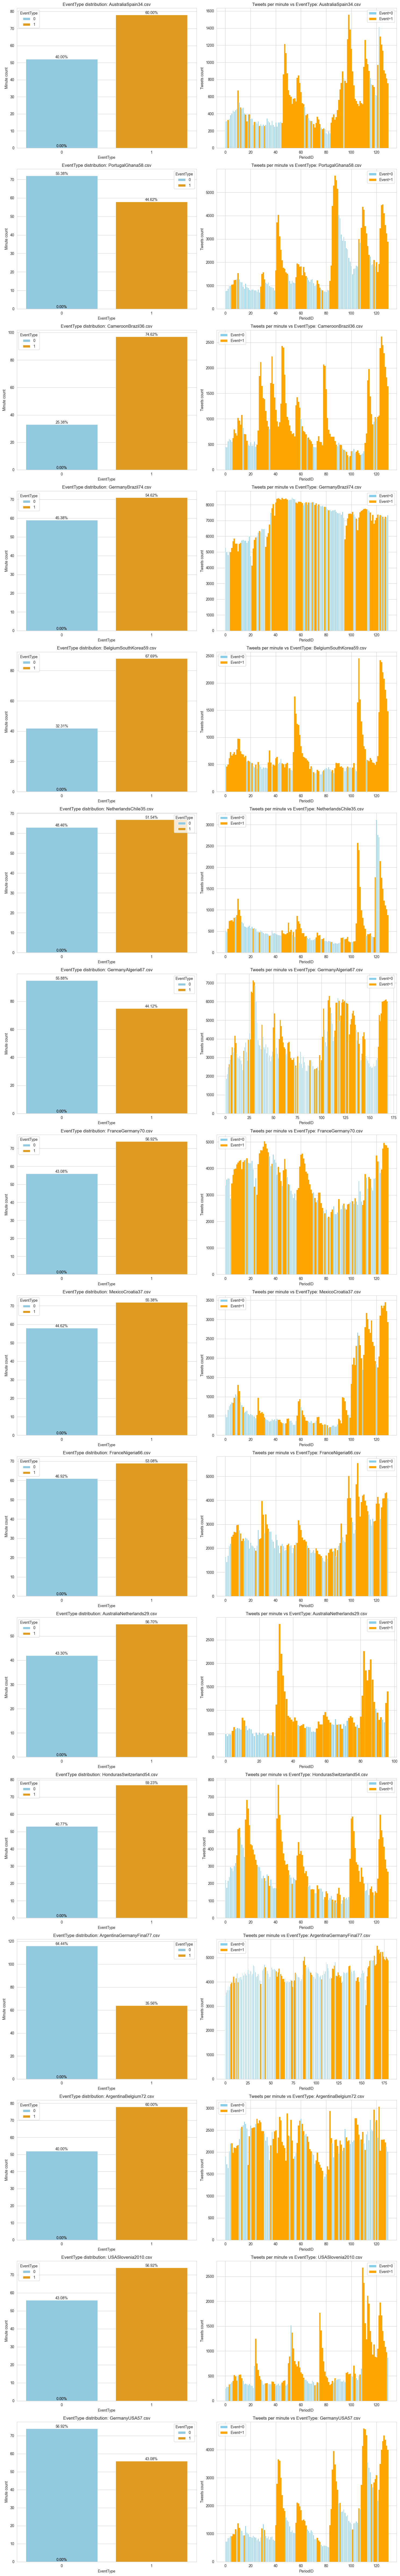

In [7]:
num_files = len(csv_files)
cols = 2
rows = num_files * 2 // cols + 1

plt.figure(figsize=(15, num_files * 6))

for i, file in enumerate(csv_files):
    file_name = os.path.basename(file)
    df = pd.read_csv(file)

    # check_data_quality(df, file_name)

    df_clean = clean_data(df)

    plt.subplot(num_files, 2, 2 * i + 1)
    plot_eventtype_distribution(df_clean, plt.gca(), file_name)

    plt.subplot(num_files, 2, 2 * i + 2)
    plot_tweets_vs_event(df_clean, plt.gca(), file_name)

plt.tight_layout()
plt.show()